# Summary

Milestone 3 of reinforcement learning project. Notebook to get a GMRES that (1) works on GPU and (2) works with batched data.

## TODO

1. Finish testing.
2. Setup dataset from other notebook.
3. Integrate the GPU GMRES with the loss to see how much a single step will cost.
4. Improve loss from Milestone 2.
    1. Vectorize it.
    2. Additional terms for sparsity?
5. Begin to pretrain actor.
    1. First experiment with models.
        1. Minimize eye_dist.
        2. Try different layers.
        3. Try edge prediction. 
        4. REALLY TRY TO GET SPARSITY. (Log-sum penalty) ?
    2. Anything that works, store in a python file.
    3. Build out a python file that has models that have worked.
    4. Make sure to save weights and successfully plots to /Weights and /Plots
6. Train just on small (results).
7. Train just on large (results).
8. Train SMALLER -> freeze middle -> finetune on large.
9. If SMALLER -> LARGER leads to shorter training times and >= results, include as a novelty presented in paper (like many PDE discretization techniques, it is common to control the size, we found results that suggest that the model can generalize well to smaller discretization spaces and be applied effectively to larger state spaces).

# Dataset

Same helmholtz dataset from milestone 2.

In [1]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import dense_to_sparse
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
import torch

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

In [2]:
def generate_random_helmholtz(n, density=0.1):
    L = 1.0
    k = np.random.uniform(1, 2)  # Random wavenumber
    h = L / (n - 1)  

    # Discretization of Helmholtz operator (1D)
    diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]

    helmholtz = sp.diags(diagonals, [-1, 0, 1]) / h**2 + k**2 * sp.eye(n)

    # Ensure no perturbations on the tridiagnonal
    perturb = sp.random(n, n, density=density) * np.max(helmholtz)
    
    perturb.setdiag(0)  # Main diagonal
    perturb.setdiag(0, k=1)  # First upper diagonal
    perturb.setdiag(0, k=-1)  # First lower diagonal
        
    return helmholtz

In [3]:
def test_singularity(mat):
    det_mat = np.linalg.det(mat)
    print(det_mat)

    if np.isclose(det_mat, 0):
        print("Matrix is singular.")
        return False
        
    rank_mat = np.linalg.matrix_rank(mat)
    if rank_mat < mat.shape[0]:
        print("Matrix is singular.")
        return False
    
    print("Matrix is non-singular.")
        
    return True

In [4]:
def normalize_features(graph_data):
    x_min = graph_data.min()
    x_max = graph_data.max()
    out = (graph_data - x_min) / (x_max - x_min + 1e-8)
    return out.float()

def normalize_edge_attr(graph_data):
    e_min = graph_data.min()
    e_max = graph_data.max()
    out = (graph_data - e_min) / (e_max - e_min + 1e-8)
    return out.float()

In [5]:
class HelmHoltzDataset(Dataset):
    def __init__(self, generator, checker, norm_feat, norm_edge, epoch_len, size=20, density=0.1, transform=None):
        super().__init__(None, transform)
        
        self.epoch_len = epoch_len
        self.mat_size = size
        self.mat_density = density
        
        self.generator = generator
        self.checker = checker
        
        self.norm_features = norm_feat
        self.norm_edge_attr = norm_edge

    def len(self):
        return self.epoch_len

    def get(self, idx):
        A = self.generator(self.mat_size, self.mat_density).toarray()
        source_nodes, target_nodes = A.nonzero()
        edge_weights = torch.from_numpy(A[source_nodes, target_nodes])
        source_nodes = torch.from_numpy(source_nodes)
        target_nodes = torch.from_numpy(target_nodes)
        edge_index = torch.stack([source_nodes, target_nodes], dim=0).to(torch.int64)
        
        b = torch.randn(self.mat_size).unsqueeze(-1)
        
        node_features = self.norm_features(b)
        edge_weights = self.norm_edge_attr(edge_weights)

        data = Data(x=b, edge_index=edge_index, edge_attr=edge_weights)
        return torch.from_numpy(A), data

In [6]:
dataset = HelmHoltzDataset(generate_random_helmholtz, test_singularity, normalize_features, normalize_edge_attr, 64*1000)
vdataset = HelmHoltzDataset(generate_random_helmholtz, test_singularity, normalize_features, normalize_edge_attr, 64*100)

In [7]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
vdataloader = DataLoader(vdataset, batch_size=1, shuffle=True)

## Loss Integration

Identity distance from Milestone 2 (with vectorized form). This will be the form going forward.

In [8]:
from torch import nn

In [9]:
class IdenittyDistance(nn.Module):
    def __init__(self, l1=None, logsum=None):
        super().__init__()
        self.l1 = l1
        self.logsum = logsum
        self.size = 20
        
    def forward(self, inp, outp):
        inp = inp.to(device, torch.float32)
        avg_loss = 0
        
        batch_size = 1
        identity = torch.eye(self.size, device=device).expand(batch_size, -1, -1)
        inner_product = torch.bmm(outp.view(batch_size, self.size, self.size), inp.view(batch_size, self.size, self.size))
        det = torch.mean(torch.abs(torch.linalg.det(inner_product))).item()
        
        # TODO : Pre-pre, idk man
        
        # Maximize the determinent | Minimize the condition number     
        if False and det < 1.0:
            slog_det = torch.log(torch.abs(torch.linalg.det(inner_product)))
            avg_loss += -torch.mean(slog_det) * 1.0
            
        else:
            #eye_frobenius_loss = torch.norm(inner_product - identity, p='fro', dim=(1, 2))
            #avg_loss += torch.mean(eye_frobenius_loss) * 1.0
        
            singular_values = torch.linalg.svdvals(inner_product)
            log_singular_values = torch.log(singular_values)
            log_cond = log_singular_values.max(dim=1).values - log_singular_values.min(dim=1).values
            avg_loss += torch.mean(log_cond) * 1.0
        
            if self.l1 is not None:
                avg_loss += self.l1 * torch.norm(outp, p=1) * 1.0
            elif self.logsum is not None:
                avg_loss += torch.sum(torch.log(1 + torch.abs(outp) / self.logsum))
        
        return avg_loss

# Models

Potential models for actor network.

**NOTE:** Aim for a model roughly 10 GBs in size. Need room for critic, actor, and GMRES. 

In [10]:
from tqdm.notebook import tqdm
import torch.optim as optim
import torch.nn.utils as nn_utils

In [11]:
def shared_training_loop(epoches, criterion, train_loader, valid_loader, model, lr, b=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, threshold=1e-3)

    train_log, valid_log = np.zeros(epoches), np.zeros(epoches)
    
    for epoch in range(epoches):
        
        train_loss = 0
        model.train()
        t_loader = tqdm(train_loader, desc=f'Train', leave=False, mininterval=2.0)
        for batch in t_loader:
            A, batch = batch
            batch = batch.to(device)
            output = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
            loss = criterion(A, output.to_dense())

            t_loader.set_postfix(train_loss=loss.item())
            train_loss += loss.item()

            optimizer.zero_grad() 
            loss.backward()
            optimizer.step()
            
        valid_loss = 0
        model.eval()
        v_loader = tqdm(valid_loader, desc=f'Valid', leave=False, mininterval=2.0)
        for batch in v_loader:
            with torch.no_grad():
                A, batch = batch
                batch = batch.to(device)
                output = model(batch.x, batch.edge_index, batch.edge_attr, batch.batch)
                loss = criterion(A, output.to_dense())

                v_loader.set_postfix(valid_loss=loss.item())
                valid_loss += loss.item()
                
        print(f'Epoch: {epoch}, Train: {train_loss/len(t_loader)}, Valid: {valid_loss/len(v_loader)}')
        train_log[epoch], valid_log[epoch] = train_loss, valid_loss
        
        scheduler.step(valid_loss)
        
    return train_log, valid_log

In [12]:
import matplotlib.pyplot as plt

In [13]:
def plot_training(train_log, valid_log, title='EX', filename='ex'):
    plt.plot(train_log, label="Train")
    plt.plot(valid_log, label="Valid")
    plt.title(f'{title}: Train/Valid Log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.savefig(f'{filename}.png')
    plt.show()

## (Edge Prediction) Models

Models in which the node features are passed in pairs to linear layers and compute an edge weight.

Sharing a training loop means some things like edge prediction will happen within the model class.

This model fixes the sparsity to be exactly the same as the input by only computing entries on the edge indexes.

## TODO

Model from NeuralIF paper.

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [16]:
from neuralIncompleteFactorization.neuralif import models

In [17]:
kwargs = {
    "latent_size": 16, 
    "message_passing_steps": 4, 
    "skip_connections": 1,                  
    "augment_nodes": 1, 
    "global_features": 0, 
    "decode_nodes": 4,                  
    "normalize_diag": True, 
    "activation": True, 
    "aggregate": None, 
    "graph_norm": None,
    "two_hop": None, 
    "edge_features": 4, 
    "normalize": None
}

model = models.NeuralPCG(**kwargs)

In [18]:
from neuralIncompleteFactorization.apps import synthetic

In [22]:
model(next(iter(dataloader))[1])

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x58 and 1x16)

### TransformerConv

Uses a transformer network to pass messages.

This model is very broken. Some sort of index out of bounds, need to figure out where the issue is.

In [317]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [318]:
from torch_geometric.nn import TransformerConv, GraphConv

In [319]:
class GraphTransformer(nn.Module):
    def __init__(self, in_channels=1, out_channels=20, hidden_channels=128, heads=5, dropout=0.25, num_layers=5):
        super(GraphTransformer, self).__init__()
        
        self.activation = nn.ReLU()
        self.layers = nn.ModuleList()
        
        self.layers.append(GraphConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.layers.append(GraphConv(hidden_channels, hidden_channels))
        self.layers.append(GraphConv(hidden_channels, out_channels))
        
        self.edge_scorer = nn.Linear(2 * out_channels, 1)  

    def forward(self, x_in, edge_index, edge_attr, batch):
        x = x_in
        for conv in self.layers:
            x = conv(x, edge_index, edge_attr)
            x = self.activation(x)
            
        # Compute edge scores
        row, col = edge_index  # source and target node indices for each edge
        edge_features = torch.cat([x[row], x[col]], dim=-1)  # Concatenate source and target embeddings
        edge_scores = self.edge_scorer(edge_features).squeeze(-1)  # Shape: (num_edges,)
        
        # Initialize batched sparse matrices
        num_nodes = 20
        batch_size = batch.max().item() + 1
        
        # Select edges belonging to the i-th graph in the batch
        batch_mask = (batch[row] == 0)
        batch_edges = edge_index[:, batch_mask]
        batch_scores = edge_scores[batch_mask]

        # Create a sparse matrix for the i-th graph
        sparse_matrix = torch.sparse_coo_tensor(
            batch_edges,
            batch_scores,
            (num_nodes, num_nodes)
        )
                        
        return sparse_matrix

In [320]:
gtransformer = GraphTransformer()

In [321]:
epoches = 10
loader = dataloader
vloader = vdataloader
model = gtransformer.to(device)
lr = 1e-5

In [322]:
criterion = IdenittyDistance()

In [323]:
train_log, valid_log = shared_training_loop(epoches, criterion, loader, vloader, model, lr, b=True)

Train:   0%|          | 0/64000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [309]:
def normalize_features(graph_data):
    return graph_data

In [310]:
def testing(model, dataload):
    A, d = next(iter(dataload))
    d = d.to(device)
    out = model(d.x, d.edge_index, d.edge_attr, d.batch).detach().cpu().to_dense()
    d = d.cpu()
    #test_singularity(d.x), test_singularity(normalize_features(generate_random_helmholtz(500).toarray()))
    
    print(torch.norm(out.detach().cpu() @ A.float() - torch.eye(20), p=2))
    print(torch.norm(out.detach().cpu() @ A.float(), p=2))
    print(torch.norm(out.detach().cpu(), p=2))
    print(torch.norm(torch.eye(20), p=2))
    print(torch.linalg.det(out.to_dense().detach().cpu()))
    print(torch.linalg.det(A.float()))
    
    print(torch.abs(torch.linalg.det(out.detach().cpu() @ A.float())))
    print(torch.abs(torch.linalg.det(out.detach().cpu() @ A.float())))
    plt.matshow(out.to_dense().detach().cpu())
    plt.matshow(A[0])
    plt.matshow(out.detach().cpu() @ A[0].float())

tensor(1452.3247)
tensor(1452.3969)
tensor(3.3735)
tensor(4.4721)
tensor(7.1423e-10)
tensor([inf])
tensor([inf])
tensor([inf])


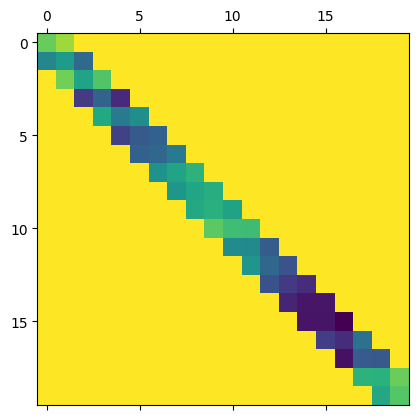

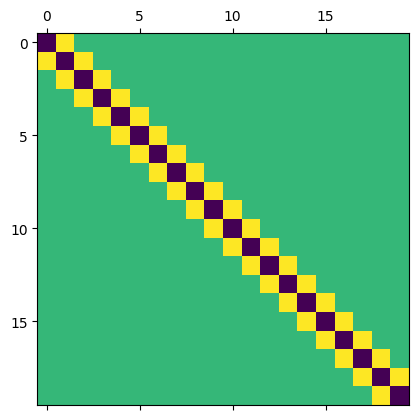

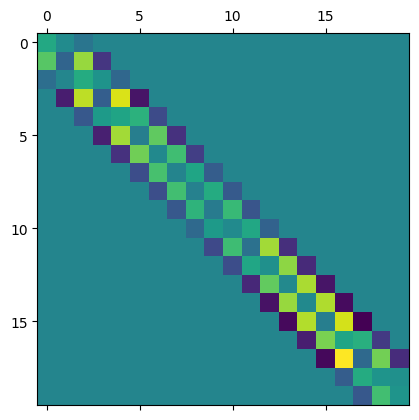

In [311]:
testing(gtransformer, dataloader)

## (Misc) Models

Models I just had an idea with. Not sure if I will use this section, but its here.